# Data Exploration

### Questions

What does the distribution of each variable look like?

Are there any correlations that we should know of?

Which variables are useful? Which aren't? Why?

Are there any patterns that we can discern between one or more independent variables and our dependent variable (isSold)?

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA

In [37]:
df = pd.read_csv('data/train.csv')

df.head()

,auctionId,timeStamp,placementId,websiteId,hashedRefererDeepThree,country,opeartingSystem,browser,browserVersion,device,environmentType,integrationType,articleSafenessCategorization,isSold
0,0024b36a-4fb5-4070-88fb-fc0bfb1909ed,1603974586,69454,42543,df1108bf6ae49dbccf5eab60ff9d04a6a09dda60ec7290...,RO,Android,Facebook App,293_0,Phone,js-fbwv,1,unsafe,False
1,010aa3a7-819c-4cdf-ab98-41de03e98ad7_2a1ae03a-...,1604248341,120706,68203,8f94cf5f1e4c7541162a1b17079e8cc4cdc0b7f69ee886...,US,iOS,Facebook App,NaN,Phone,js-web,2,safe,False
2,011c2268-4091-4ce1-a62a-b96626806808_7ab7385f-...,1604226053,120706,68203,8448d2635d8ce25f3758907451fc740c4b2131693c7a8b...,AU,Android,Facebook App,294_0,Phone,js-web,2,safe,False
3,02075e25-9be2-4c5e-804b-d19d42bb2ddb_3eb4171c-...,1604052768,120706,68203,8448d2635d8ce25f3758907451fc740c4b2131693c7a8b...,US,iOS,Facebook App,NaN,Phone,js-web,2,safe,False
4,02728aa7-09ee-45ee-8f86-395c30066c40_61088bde-...,1604008787,128131,72196,6f220ed56952bc95b4a884da5bed8a875cf4c47c76d402...,DE,Android,Facebook App,294_0,Phone,js-web,2,safe,True


# Preprocessing

Do some factorization to get the data ready for a RF classifier. Split the data into testing and training sets.

In [77]:
# factorize all non-numerical vars
def factorize_df(df):
  df['auctionId'] = pd.factorize(df['auctionId'])[0]
  df['hashedRefererDeepThree'] = pd.factorize(df['hashedRefererDeepThree'])[0]
  df['country'] = pd.factorize(df['country'])[0]
  df['opeartingSystem'] = pd.factorize(df['opeartingSystem'])[0]
  df['browser'] = pd.factorize(df['browser'])[0]
  df['device'] = pd.factorize(df['device'])[0]
  df['environmentType'] = pd.factorize(df['environmentType'])[0]
  df['articleSafenessCategorization'] = pd.factorize(df['articleSafenessCategorization'])[0]
  return df

In [78]:
# Split the data into attr and target
df = factorize_df(df)
X = df.drop('isSold', axis=1)
y = df['isSold']

In [79]:
df.head()

,auctionId,timeStamp,placementId,websiteId,hashedRefererDeepThree,country,opeartingSystem,browser,browserVersion,device,environmentType,integrationType,articleSafenessCategorization,isSold
0,0,1603974586,69454,42543,0,0,0,0,293_0,0,0,1,0,False
2,1,1604226053,120706,68203,1,1,0,0,294_0,0,1,2,1,False
4,2,1604008787,128131,72196,2,2,0,0,294_0,0,1,2,1,True
5,3,1604149192,120706,68203,3,3,0,0,294_0,0,1,2,1,False
7,4,1603975681,120706,68203,4,4,0,0,293_0,1,1,2,0,True


In [80]:
# drop samples with NaN values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.dropna(inplace=True)
y_train.dropna(inplace=True)
X_test.dropna(inplace=True)
y_test.dropna(inplace=True)

# Optimize Random Forest Classifier

we do this by finding the optimal number of estimators (trees) to include in our random forest.

In [81]:
# Define the range of n_estimators to test
estimator_range = range(10, 101, 10)

# Create an empty list to store the mean cross-validation scores
cv_scores = []

# Loop through each value of n_estimators and calculate the cross-validation score
for n_estimators in estimator_range:
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find the optimal number of estimators with the highest cross-validation score
optimal_n_estimators = estimator_range[cv_scores.index(max(cv_scores))]
print("The optimal number of estimators is:", optimal_n_estimators)

The optimal number of estimators is: 90


In [82]:
# run RF classifier (goal: determine feature importance)
rf = RandomForestClassifier(n_estimators=90, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=90, random_state=42)

# Feature Importance

Let's take a look into the random forest classifier to see which variables it used to make decisions regarding an auction being sold or not.

In [83]:
# Calculate feature importance
importances = rf.feature_importances_
feature_names = X_train.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)

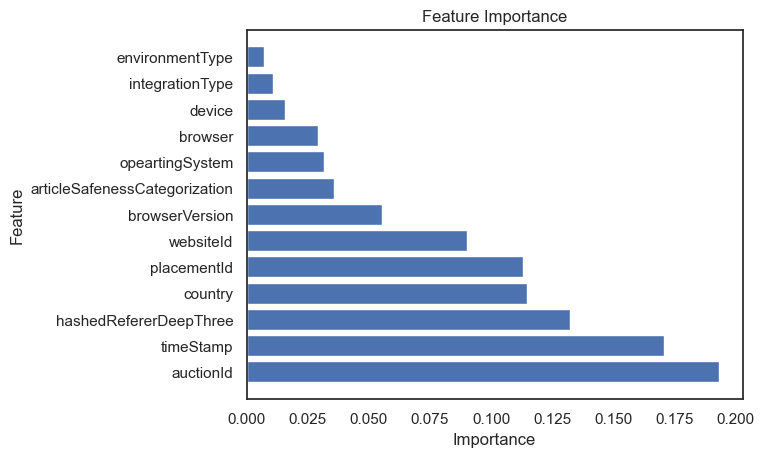

In [84]:
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Data Exploration Results

Looks like timeStamp and auctionId are among the most important features when used to predict an auction's outcome... why?

In [85]:
# initial accuracy 
y_pred_test = rf.predict(X_test)
accuracy_score(y_test, y_pred_test)

0.7487491065046462

## Results

74 percent is decent (already higher than the top entry on Kaggle lol), but can we explain what is going on?

In [86]:
df.head()

,auctionId,timeStamp,placementId,websiteId,hashedRefererDeepThree,country,opeartingSystem,browser,browserVersion,device,environmentType,integrationType,articleSafenessCategorization,isSold
0,0,1603974586,69454,42543,0,0,0,0,293_0,0,0,1,0,False
2,1,1604226053,120706,68203,1,1,0,0,294_0,0,1,2,1,False
4,2,1604008787,128131,72196,2,2,0,0,294_0,0,1,2,1,True
5,3,1604149192,120706,68203,3,3,0,0,294_0,0,1,2,1,False
7,4,1603975681,120706,68203,4,4,0,0,293_0,1,1,2,0,True


# Classification Report

A simple accuracy score doesnt tell the full story. 

We see that the model is overall better at predicting when an auction is NOT sold. This may be because there are 2k more instances of unsold auction samples for the data to train on. Precision tells us what percent of predictions the model got correct, while accuracy tells us what percent of the total amount of correct predictions did the model accurately predict. In this instance, the model had a higher recall than precision, but they were close enough for it to be statistically insignificant.

In [87]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       False       0.76      0.80      0.78      9234
        True       0.74      0.69      0.71      7554

    accuracy                           0.75     16788
   macro avg       0.75      0.74      0.74     16788
weighted avg       0.75      0.75      0.75     16788



# Confusion Matrix Heatmap

This basically tells me what the model had struggle predicting. From here, I can see that the model was better able to predict failed auctions than it was able to predict successful auctions. 

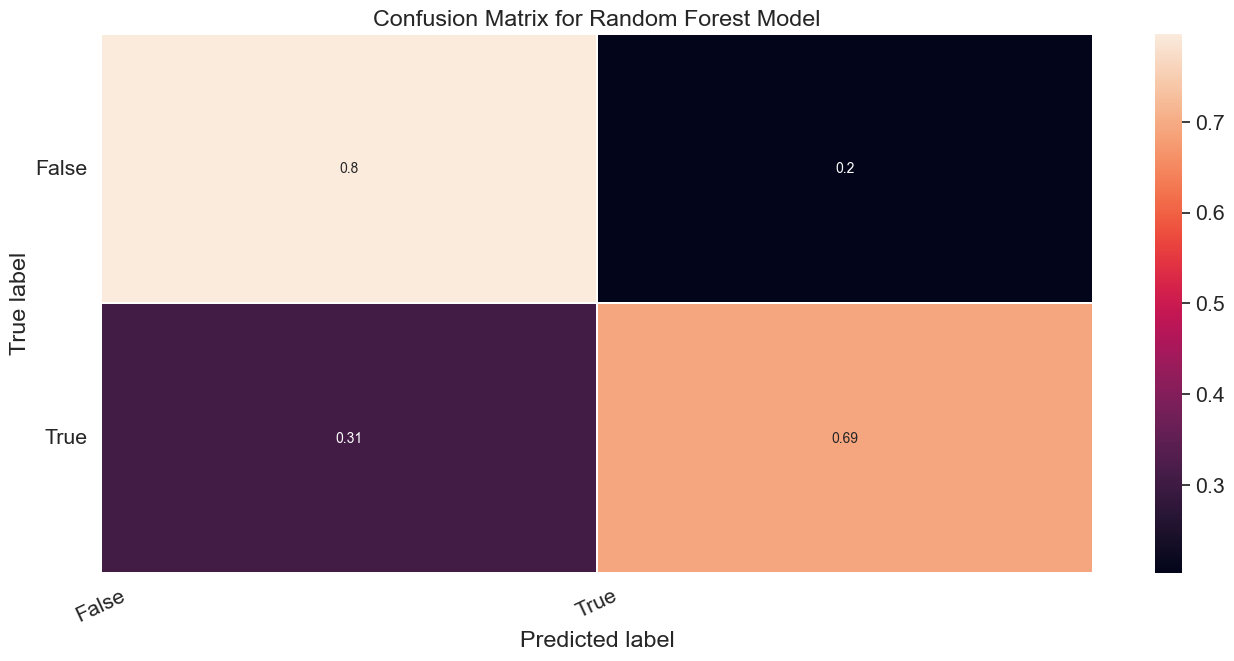

In [88]:
# use heatmap confusion matrix to figure out what is going wrong

# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10}, linewidths=0.2)

# Add labels to the plot
class_names = "False True".split(' ')

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [89]:
df.corr()

,auctionId,timeStamp,placementId,websiteId,hashedRefererDeepThree,country,opeartingSystem,browser,browserVersion,device,environmentType,integrationType,articleSafenessCategorization,isSold
auctionId,1.000000,-0.007711,-0.056792,-0.128226,0.722465,0.025921,-0.062346,0.022168,0.001181,-0.119036,0.048758,-0.053896,-0.022478,0.100213
timeStamp,-0.007711,1.000000,0.000043,0.015312,-0.013147,-0.014799,-0.014940,-0.004587,0.002423,-0.045579,0.004702,0.003628,-0.012061,0.006336
placementId,-0.056792,0.000043,1.000000,0.503096,-0.052000,-0.054703,0.096707,-0.030434,0.002031,0.120686,-0.095945,0.499816,0.074047,-0.121235
websiteId,-0.128226,0.015312,0.503096,1.000000,-0.020295,-0.078595,-0.000861,-0.069608,0.004734,0.037858,-0.093675,0.228170,0.111315,-0.023724
hashedRefererDeepThree,0.722465,-0.013147,-0.052000,-0.020295,1.000000,0.000734,-0.079297,-0.004533,-0.003304,-0.079329,0.034103,-0.034799,0.023954,0.117353
country,0.025921,-0.014799,-0.054703,-0.078595,0.000734,1.000000,-0.107964,0.060426,-0.001528,-0.082353,0.012879,-0.154280,0.019483,-0.157332
opeartingSystem,-0.062346,-0.014940,0.096707,-0.000861,-0.079297,-0.107964,1.000000,0.114994,0.004168,0.353543,-0.023681,0.086739,-0.003702,-0.136575
browser,0.022168,-0.004587,-0.030434,-0.069608,-0.004533,0.060426,0.114994,1.000000,0.060028,-0.046893,0.140241,-0.066449,-0.004677,-0.046074
browserVersion,0.001181,0.002423,0.002031,0.004734,-0.003304,-0.001528,0.004168,0.060028,1.000000,0.010586,-0.001169,0.003368,0.006193,-0.006326
device,-0.119036,-0.045579,0.120686,0.037858,-0.079329,-0.082353,0.353543,-0.046893,0.010586,1.000000,-0.088928,0.117237,0.015003,-0.156449


# Correlation matrix findings

The correlation matrix confirms that we don't have any single variable - correlations between attributes and isSold

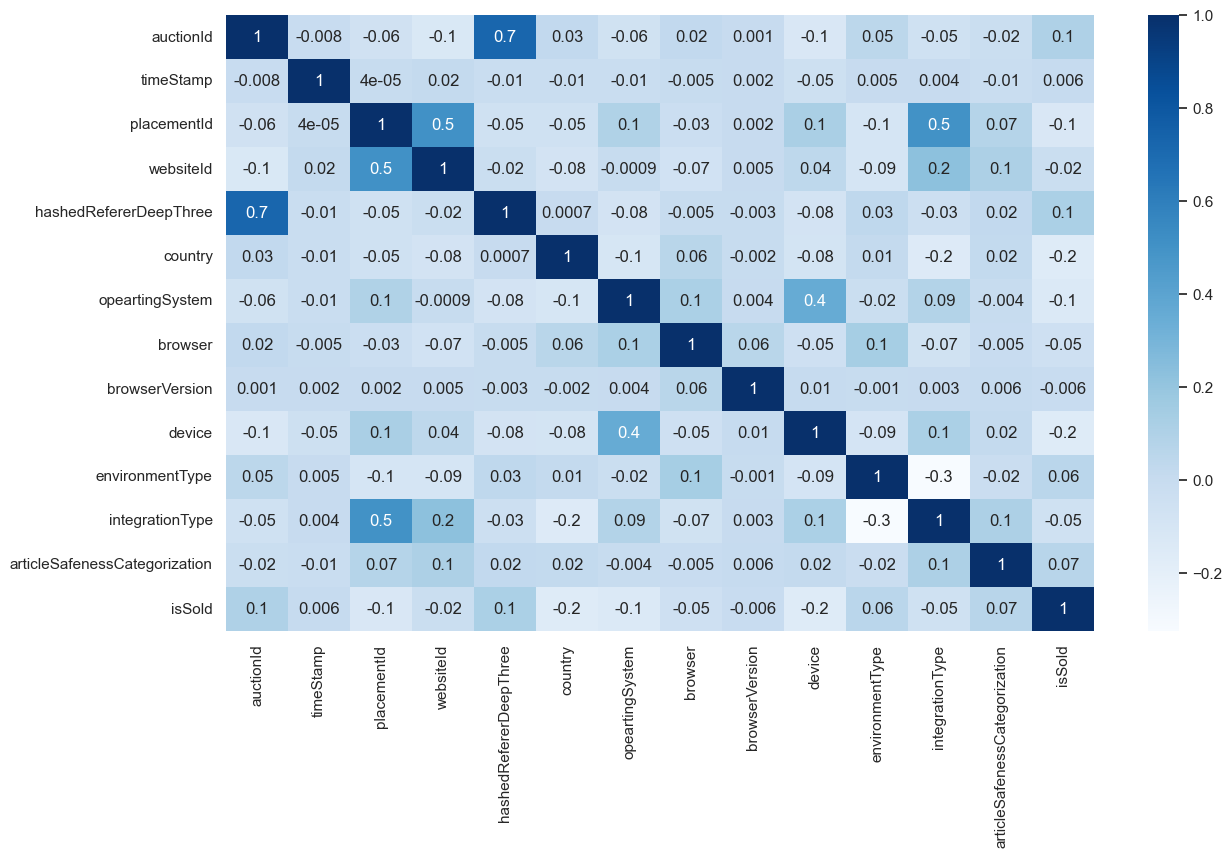

In [90]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = df.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

In [91]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Apply PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Create a new dataframe with the principal components and target variable
df_pca = pd.DataFrame({'PC1': X_pca[:, 0], 'PC2': X_pca[:, 1], 'target': y})

# PCA Analysis

I tried to see if there was any separation between auctions that were sold and auctions that weren't. Turns out there isn't much separation between the two. This indicates that the data is not separatable with a linear decision boundary.

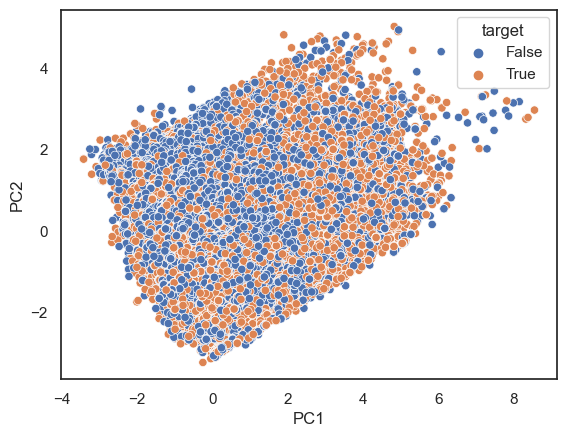

In [92]:
sns.scatterplot(x='PC1', y='PC2', hue='target', data=df_pca)
plt.show()

In [93]:
test_df = pd.read_csv('data/test.csv')

test_df.head()

,auctionId,timeStamp,placementId,websiteId,hashedRefererDeepThree,country,opeartingSystem,browser,browserVersion,device,environmentType,integrationType,articleSafenessCategorization
0,01943aa0-c202-4052-af7c-4478a4fbd651_c5281852-...,1603987450,127285,71799,b4ac53247235c618d78cca83f112cd68bacf562dc575b2...,UK,Android,Chrome Mobile,86_0,Phone,js-web,2,uncat
1,0368c9f2-3f7e-424f-9d41-16e0b45400cd_1b65693d-...,1603726992,132055,46458,b37fb57f0189132d2251099a03f0fd525a1c188b65f5c0...,US,Chrome OS,Chrome,85_0,PC,js-web,2,safe
2,038c7d6e-74e6-46b2-9691-c57ba7388c61_21d8420b-...,1603839406,121842,68951,e01175c1daea2889a6c8801cf8013bdf143f56bb99c2a2...,US,macOS,Safari,14_0,PC,js-web,2,safe
3,0a74e7ff-f4f3-444c-a67e-d36a76abe030,1603708830,103396,53219,14e75ac9db6faf4ea13c260ccb3e0f8229ee058619debc...,MX,Android,Chrome Mobile,36_0,Phone,js-amp,1,unsafe
4,0bed9764-8882-46ae-a93e-d4e3ad73cc30_ba86b50c-...,1603786935,66981,41405,7881f3d716b442b033c331e1fbcc31f99b9c29f248b8dc...,US,Android,Chrome Mobile,80_0,Phone,js-web,2,safe


In [96]:
test_df = factorize_df(test_df)
test_df.dropna(inplace=True)

test_df.head()

,auctionId,timeStamp,placementId,websiteId,hashedRefererDeepThree,country,opeartingSystem,browser,browserVersion,device,environmentType,integrationType,articleSafenessCategorization
0,0,1603987450,127285,71799,0,0,0,0,86_0,0,0,2,0
1,1,1603726992,132055,46458,1,1,1,1,85_0,1,0,2,1
2,2,1603839406,121842,68951,2,1,2,2,14_0,1,0,2,1
3,3,1603708830,103396,53219,3,2,0,0,36_0,0,1,1,2
4,4,1603786935,66981,41405,4,1,0,0,80_0,0,0,2,1


In [97]:
# initial accuracy 
y_pred_test = rf.predict(test_df)

# Kaggle Submission

I am assuming that, when the Kaggle competition was open, they would require you to submit your predictions to the train.csv values. I am also assuming that they have some answer key to check my predictions against. The competition is closed now, so we cannot test this. Nevertheless, this would result in an accuracy of 74% with high statistical likelihood because of the experiements I showed with my train set.

In [99]:
y_pred_test

array([False, False, False, ..., False,  True,  True])